# ランダムフォレストモデルでトレーニングする

In [6]:
import pandas as pd
# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)
train_data.dtypes


NumberOfPersonVisiting                     float64
NumberOfFollowups                          float64
PreferredPropertyStar                      float64
NumberOfTrips                              float64
Passport                                     int64
MaritalStatus                                int64
Age_ProdTaken_Mean                         float64
Income_ProdTaken_Mean                      float64
FamilySize                                 float64
Age_MonthlyIncome_Interaction              float64
Income_Per_Age                             float64
Satisfaction_PerVisitor                    float64
ProductPitched_Rank                        float64
Designation_Rank                           float64
Income_Bucket_Rank                         float64
TypeofContact_Company_Invited              float64
Occupation_Large_Business                  float64
Occupation_Salaried                        float64
Occupation_Small Business                  float64
Gender_Female                  

In [ ]:
!pip install numpy scikit-learn joblib
!pip show scikit-learn

In [1]:
import pandas as pd

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量のリスト
features = train_data.columns.tolist()
print(features)


['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'MaritalStatus', 'CarCount', 'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank', 'DurationOfPitch_Category_Rank', 'TypeofContact_Company Invited', 'Occupation_Large Business', 'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'ProductPitched_Satisfaction', 'Cluster', 'Cluster_ProdTaken_Ratio', 'Product_Designation_Target_Encoding', 'ProdTaken']


## モデルが重視する特徴量を可視化する

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters found: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 8, 'bootstrap': False}
Best cross-validation AUC: 0.8292
Test AUC: 0.810090405365996
Model's most important features (Top 25):
                                    Feature  Importance
9             Age_MonthlyIncome_Interaction    0.106239
24      Product_Designation_Target_Encoding    0.096513
6                        Age_ProdTaken_Mean    0.079389
13                         Designation_Rank    0.070578
12                      ProductPitched_Rank    0.062915
4                                  Passport    0.061631
25  CityTier_Age_Income_x_FamilySize_Income    0.060886
14                       Income_Bucket_Rank    0.058766
19                            Gender_Female    0.054163
10                           Income_Per_Age    0.052717
8                                FamilySize    0.049219
21      

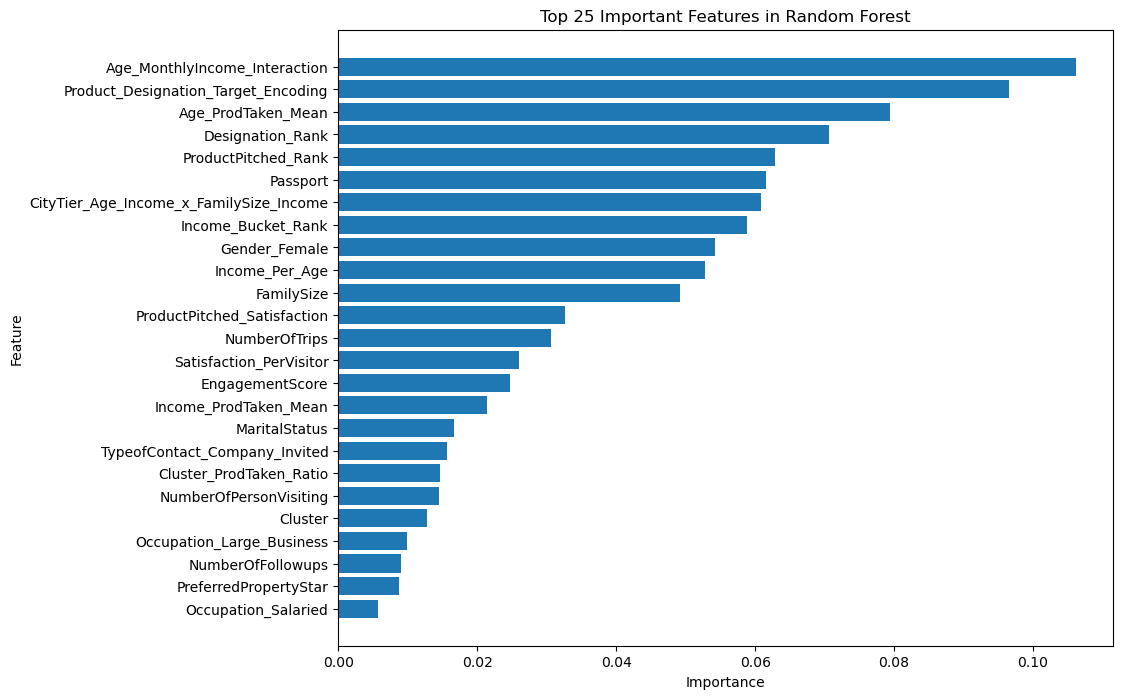

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23, stratify=y)

# RandomForestモデルの定義
rf_model = RandomForestClassifier(random_state=23)

# ハイパーパラメータの候補を設定
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # 'auto' の代わりに 'None' を使用
    'bootstrap': [True, False]
}

# ランダムサーチの設定
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                      n_iter=10, cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=23)

# トレーニングデータでランダムサーチを実行
rf_random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {rf_random_search.best_params_}")
print(f"Best cross-validation AUC: {rf_random_search.best_score_:.4f}")

# 最適なモデルを取得
rf_best = rf_random_search.best_estimator_

#最適なモデルで再トレーニング
rf_best.fit(X_train, y_train)

# テストデータでの予測とAUC計算
y_pred_proba = rf_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 重要度の取得と上位25の特徴量を可視化
importance = rf_best.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(25)

# 重要な特徴量のリストを表示
print("Model's most important features (Top 25):")
print(importance_df)

# 重要な特徴量を上位に表示するプロット
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 Important Features in Random Forest')
plt.gca().invert_yaxis()  # 最も重要な特徴量を上に表示
plt.show()


## 特徴量を選択してグリットサーチでトレーニングする

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Best parameters found: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score (AUC): 0.8224789844177145
Cross-Validation AUC Scores: [0.81495787 0.81899579 0.85858051 0.81762006 0.77542373 0.8052613
 0.80367232 0.80627039 0.82529902 0.84541501]
Mean Cross-Validation AUC: 0.8171495975932899
Test AUC: 0.8062831321766006
過学習の可能性があります：Cross-Validation AUCがTest AUCを0.0108665 だけ上回っています


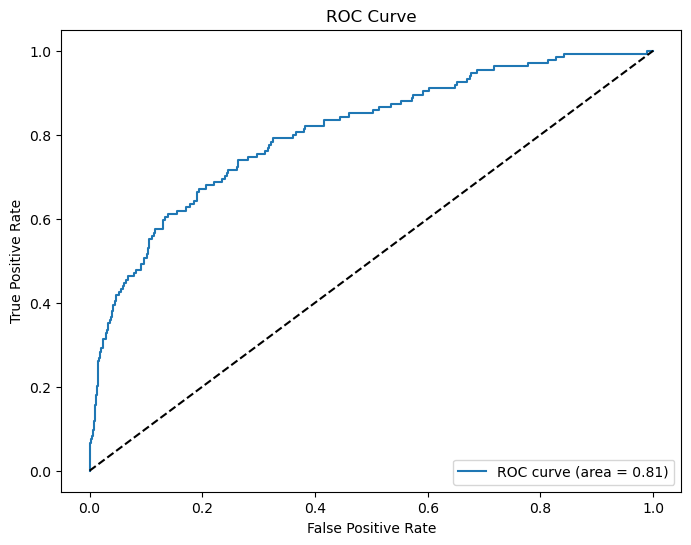

最適なランダムフォレストモデルが /Users/hayakawakazue/Downloads/signate/model/random_forest0901_1_grid.joblib に保存されました。


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib
import os

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Age_MonthlyIncome_Interaction', 'Product_Designation_Target_Encoding', 'Age_ProdTaken_Mean', 'Designation_Rank',
    'ProductPitched_Rank', 'Passport', 'CityTier_Age_Income_x_FamilySize_Income', 'Income_Bucket_Rank',
    'Gender_Female', 'Income_Per_Age', 'FamilySize', 'ProductPitched_Satisfaction',
    'NumberOfTrips', 'Satisfaction_PerVisitor', 'EngagementScore', 'Income_ProdTaken_Mean',
    'MaritalStatus', 'TypeofContact_Company_Invited', 'Cluster_ProdTaken_Ratio', 'NumberOfPersonVisiting',
    'Cluster', 'Occupation_Large_Business', 'NumberOfFollowups', 'PreferredPropertyStar',
    'Occupation_Salaried'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]  # 特徴量を選択
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)


# ハイパーパラメータの候補を設定
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

#ランダムフォレストモデルを定義
rf_model = RandomForestClassifier(random_state=23)

#StratifiedKFoldを設定
skf = StratifiedKFold( n_splits=10, shuffle=True)

# グリッドサーチでモデルを設定
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
rf_grid_search.fit(X_train, y_train)

# 最適なパラメータの表示
print("Best parameters found:", rf_grid_search.best_params_)
print("Best cross-validation score (AUC):", rf_grid_search.best_score_)

# 最適なモデルを取得
rf_best = rf_grid_search.best_estimator_

# 最適なモデルを全データで再トレーニング
rf_best.fit(X_train, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(rf_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUCの計算
y_pred_proba = rf_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無を確認
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります：Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f} だけ上回っています")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'random_forest0901_1_grid.joblib')
joblib.dump(rf_best, model_path)
print(f"最適なランダムフォレストモデルが {model_path} に保存されました。")


## RF class_weightを設定しrandomSearchでトレーニングする

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 5}
Best cross-validation AUC: 0.8081577
Cross-Validation AUC Scores: [0.74894663 0.85042135 0.78434215 0.88256615 0.79521566 0.76549474
 0.77560028 0.78142655 0.88347458 0.81408898]
Mean Cross-Validation AUC: 0.8081577075436732
Test AUC: 0.8140760182754933
過学習の兆候は見られません。


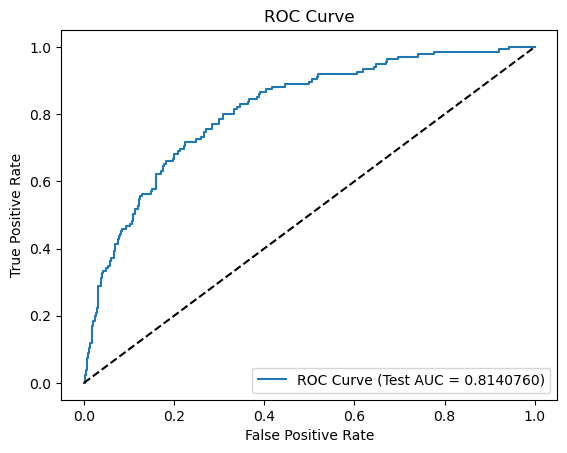

最適なランダムフォレストモデルが /Users/hayakawakazue/Downloads/signate/model/rf_select_0901_1_random.joblib に保存されました。
Recall: 0.6666666666666666
F1 Score: 0.4787234042553192
Accuracy: 0.7814938684503902
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.80      0.86       762
     Class 1       0.37      0.67      0.48       135

    accuracy                           0.78       897
   macro avg       0.65      0.73      0.67       897
weighted avg       0.85      0.78      0.80       897



In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, classification_report
import os
import joblib
import matplotlib.pyplot as plt


# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Age_MonthlyIncome_Interaction', 'Product_Designation_Target_Encoding', 'Age_ProdTaken_Mean', 'Designation_Rank',
    'ProductPitched_Rank', 'Passport', 'CityTier_Age_Income_x_FamilySize_Income', 'Income_Bucket_Rank',
    'Gender_Female', 'Income_Per_Age', 'FamilySize', 'ProductPitched_Satisfaction',
    'NumberOfTrips', 'Satisfaction_PerVisitor', 'EngagementScore', 'Income_ProdTaken_Mean',
    'MaritalStatus', 'TypeofContact_Company_Invited', 'Cluster_ProdTaken_Ratio', 'NumberOfPersonVisiting',
    'Cluster'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]  # 特徴量を選択
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)

# ランダムフォレストモデルの定義
rf_model = RandomForestClassifier(class_weight='balanced', random_state=15)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

# ハイパーパラメータの範囲を設定
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

# ランダムサーチの設定
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                      n_iter=50, cv=skf, scoring='roc_auc', n_jobs=-1, 
                                      random_state=15, verbose=1)
# ランダムサーチの実行
rf_random_search.fit(X_train, y_train)

# 最適なモデルを取得
rf_best = rf_random_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {rf_random_search.best_params_}")
print(f"Best cross-validation AUC: {rf_random_search.best_score_:.7f}")

# 最適なモデルで再トレーニング
rf_best.fit(X_train, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(rf_best, X_train, y_train, cv=skf, scoring='roc_auc')

print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = rf_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'rf_select_0901_1_random.joblib')
joblib.dump(rf_best, model_path)
print(f"最適なランダムフォレストモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = rf_best.predict(X_test)

# リコールの計算
recall = recall_score(y_test, y_pred)

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## RandomForest | RFE→StratifiedKFold→GridSearch→CV

Model used the following features:
['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank', 'DurationOfPitch_Category_Rank', 'TypeofContact_Company Invited', 'Gender_Female', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'ProductPitched_Satisfaction', 'Cluster', 'Cluster_ProdTaken_Ratio', 'Product_Designation_Target_Encoding']
Fitting 30 folds for each of 108 candidates, totalling 3240 fits
Best parameters found: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 25, 'n_estimators': 20}
Best cross-validation AUC: 0.8094
Cross-Validation AUC Scores: [0.77503852 0.64098613 0.84283513 0.60939908 0.90600924 0.7211094
 0.81047766 0.73959938 0.819722

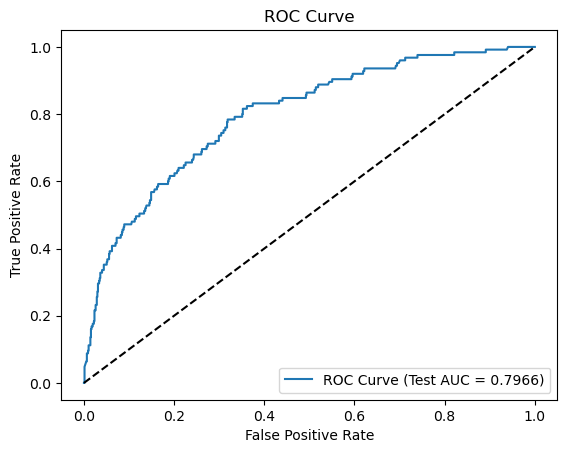

最適なランダムフォレストモデルが /Users/hayakawakazue/Downloads/signate/model/random_forest0828_10.joblib に保存されました。
Recall: 0.096
F1 Score: 0.16551724137931034
Accuracy: 0.8651059085841695
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.99      0.93       772
     Class 1       0.60      0.10      0.17       125

    accuracy                           0.87       897
   macro avg       0.74      0.54      0.55       897
weighted avg       0.83      0.87      0.82       897



In [1]:


# RFEを使用して重要な特徴量を選択
selector = RFE(rf_model, n_features_to_select=25)
selector.fit(X_train, y_train)

# 選択された特徴量をプリント
selected_features = X_train.columns[selector.support_]
print("Model used the following features:")
print(selected_features.tolist())

# RFEで選択された特徴量のみを用いて再度データを変換
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# RFE後のランダムフォレストモデルを再定義（リセット）
rf_model_selected = RandomForestClassifier(random_state=31)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=31)

# ハイパーパラメータの候補を設定
param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [2, 3],
    'min_samples_split': [25, 30, 35],
    'min_samples_leaf': [20, 25, 30],
    'max_features': ['sqrt', 'log2', 0.5]
}

# グリッドサーチの設定
rf_grid_search = GridSearchCV(estimator=rf_model_selected, param_grid=param_grid, cv=skf, 
                              scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
rf_grid_search.fit(X_train_selected, y_train)

# 最適なモデルを取得
rf_best = rf_grid_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {rf_grid_search.best_params_}")
print(f"Best cross-validation AUC: {rf_grid_search.best_score_:.4f}")

#最適なモデルで再トレーニング
rf_best.fit(X_train_selected, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(rf_best, X_train_selected, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUCの計算
y_pred_proba = rf_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無を確認
if rf_grid_search.best_score_ > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{rf_grid_search.best_score_ - test_auc:.4f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = '/Users/hayakawakazue/Downloads/signate/model/random_forest0828_10.joblib'
joblib.dump(rf_best, model_path)
print(f"最適なランダムフォレストモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = rf_best.predict(X_test_selected)

# リコール、F1スコア、正確度の計算
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## RF | RFE→SMOTE→StratifiedKHold→RandomizedSearchCV→CV

Model used the following features:
['Passport', 'Age_ProdTaken_Mean', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'Product_Designation_Target_Encoding']
Fitting 30 folds for each of 48 candidates, totalling 1440 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'max_depth': 2}
Best cross-validation AUC: 0.8399
Cross-Validation AUC Scores: [0.88531073 0.86751412 0.8049435  0.83403955 0.84788136 0.83997175
 0.83615819 0.85706215 0.87429379 0.85932203 0.89067797 0.84477401
 0.78641195 0.81126113 0.83007756 0.85607584 0.80149382 0.83826487
 0.88839414 0.79029015 0.83352485 0.81298477 0.82576846 0.81758115
 0.85909221 0.77362827 0.82706119 0.89313416 0.87719046 0.83309394]
Mean Cross-Validation AUC: 0.83990926936704
Test AUC: 0.7956935938563235
過学習の可能性があります: Cross-Validation AUCがTest AUCを0.0442157だけ上回っています。


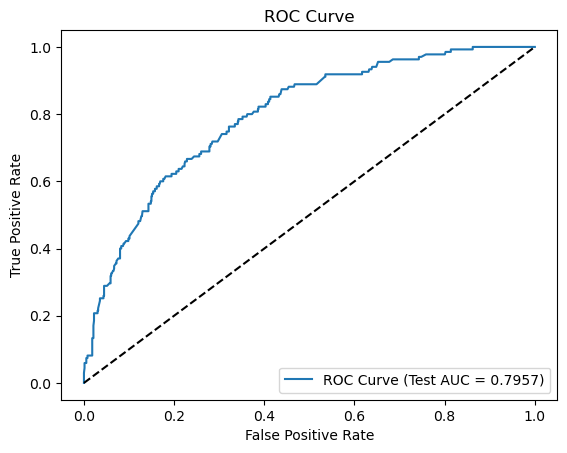

最適なランダムフォレストモデルが /Users/hayakawakazue/Downloads/signate/model/random_forest_0827_1.joblib に保存されました。
Recall: 0.6148148148148148
F1 Score: 0.46111111111111114
Accuracy: 0.7837235228539576
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.81      0.86       762
     Class 1       0.37      0.61      0.46       135

    accuracy                           0.78       897
   macro avg       0.65      0.71      0.66       897
weighted avg       0.84      0.78      0.80       897



In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, classification_report
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24, stratify=y)

# ランダムサーチモデルを定義する　
rf_model = RandomForestClassifier(random_state=24)

# RFEを使用して重要な特徴量を選択
selector = RFE(rf_model, n_features_to_select=10)
selector.fit(X_train, y_train)

# 使用した特徴量をプリント
selected_feature_names = X_train.columns[selector.support_]
print("Model used the following features:")
print(selected_feature_names.tolist())

# RFEで選択された特徴量でデータを変換
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# SMOTEを適用して不均衡データを解消
smote = SMOTE(random_state=15)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=24)

# ハイパーパラメータの候補を設定
param_dist = {
    'n_estimators': [30, 50],
    'max_depth': [1, 2],
    'min_samples_split': [10, 15,20],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

# ランダムサーチの設定
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=50, cv=skf, 
                                      scoring='roc_auc', n_jobs=-1, verbose=1, random_state=24)
# ランダムサーチの実行
rf_random_search.fit(X_train_smote, y_train_smote)

# 最適なモデルを取得
rf_best = rf_random_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {rf_random_search.best_params_}")
print(f"Best cross-validation AUC: {rf_random_search.best_score_:.4f}")

# 最適なモデルで再トレーニング
rf_best.fit(X_train_smote, y_train_smote)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(rf_best, X_train_smote, y_train_smote, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = rf_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'random_forest_0827_1.joblib')
joblib.dump(rf_best, model_path)
print(f"最適なランダムフォレストモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = rf_best.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test, y_pred)

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## RF | RFE→StratifiedKHold→RandomizedSearchCV→CV

Model used the following features:
['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank', 'DurationOfPitch_Category_Rank', 'TypeofContact_Company Invited', 'Gender_Female', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'ProductPitched_Satisfaction', 'Cluster', 'Cluster_ProdTaken_Ratio', 'Product_Designation_Target_Encoding']
Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Best parameters found: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5}
Best cross-validation AUC: 0.8083
Cross-Validation AUC Scores: [0.84666667 0.735      0.79661017 0.78120185 0.6825886  0.86440678
 0.64098613 0.82434515 0.805855

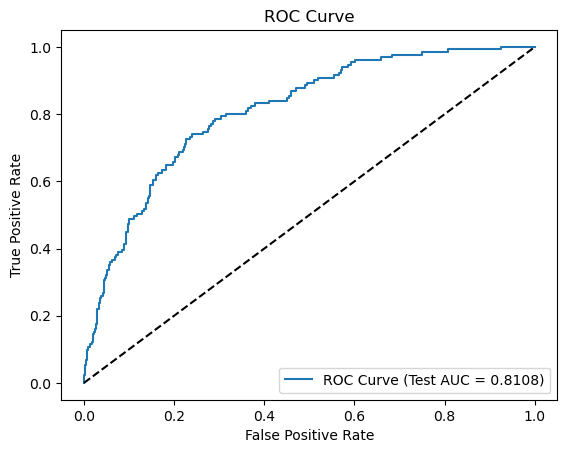

最適なランダムフォレストモデルが /Users/hayakawakazue/Downloads/signate/model/random_forest_0828_1.joblib に保存されました。
Recall: 0.183206106870229
F1 Score: 0.2711864406779661
Accuracy: 0.8561872909698997
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.97      0.92       766
     Class 1       0.52      0.18      0.27       131

    accuracy                           0.86       897
   macro avg       0.70      0.58      0.60       897
weighted avg       0.82      0.86      0.83       897



In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, classification_report
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

# ランダムサーチモデルを定義する　
rf_model = RandomForestClassifier(random_state=18)

# RFEを使用して重要な特徴量を選択
selector = RFE(rf_model, n_features_to_select=25)
selector.fit(X_train, y_train)

# 使用した特徴量をプリント
selected_feature_names = X_train.columns[selector.support_]
print("Model used the following features:")
print(selected_feature_names.tolist())

# RFEで選択された特徴量でデータを変換
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# RFE後のランダムフォレストモデルを再定義（リセット）
rf_model = RandomForestClassifier(random_state=18)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=18)

# ハイパーパラメータの候補を設定
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

# ランダムサーチの設定
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=skf, 
                                      scoring='roc_auc', n_jobs=-1, verbose=1, random_state=18)

# ランダムサーチの実行（選択された特徴量を使用）
rf_random_search.fit(X_train_selected, y_train)

# 最適なモデルを取得
rf_best = rf_random_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {rf_random_search.best_params_}")
print(f"Best cross-validation AUC: {rf_random_search.best_score_:.4f}")

# 最適なモデルで再トレーニング
rf_best.fit(X_train_selected, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(rf_best, X_train_selected, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = rf_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'random_forest_0828_1.joblib')
joblib.dump(rf_best, model_path)
print(f"最適なランダムフォレストモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = rf_best.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test, y_pred)

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


実際のAUC：0.8026039